### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# ML model (GOSS-LGBM) for `Max Temperature`

##  Read Me

This scripts contains ML model building steps for the weather variable `Maximum Temperature`. The ML model has been implemented using the [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm from [LightGBM](https://lightgbm.readthedocs.io/en/stable/) library. Detail on why GOSS has been chosen for ML modeling has been described in `Discussion.ipynb`. The modeling involves the following steps-

1. Loading Data
2. Evaluation before model performance/relationship 
3. additional data filtering 
4. train-test data split 
5. Looking into Mutual Information (MI) score to select preliminary input variables
6. Model training + hyperparameter tuning
7. Train-test dataset performance evaluation
8. Evaluating model's predictor importance plot
9. Evaluation model performance for randomly selected dates from the test dataset
10. Estimating overall model perforamcne on test dataset
11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

__Note:__
- the functions for building ML model, hyperparameter optimization, model performance evaluation, and daily improved-resolution weather data generation (interpolation) can be found at `ML_utils.ipunb` script.
- the functions for building Multi-Layered Perceptrons (MLP) model with Pytorch library and generating daily improved-resolution weather datasets can be found at `NN_Pytorch.ipunb` script.
- the general functions for  for raster data handling, era5/twc data processing/compilation, and folder handling can be found at `general_utils.ipunb` script.

In [1]:
from ipynb.fs.full.general_utils import *
from ipynb.fs.full.ML_utils import *

--------------

## 1. Loading Data

The `combined dataset` parquet file consists of weather datasets from ERA5 and TWC, along with topography and lat/lon data. Importing ERA5 and TWC datasets as well to briefly look into which variables belong to which source. 

In [2]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
twc_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_weatherdata.parquet'
combined_dataset =  '../../datasets/processed_parquet_data/cities_California/twc_era5_weather_data_cities_California.parquet'

twc_df =pd.read_parquet(twc_data)
era5_df = pd.read_parquet(era5_data)
combined_df = pd.read_parquet(combined_dataset)

print(f'TWC df columns: {twc_df.columns}')
print(f'ERA5 df columns: {era5_df.columns}')
print(f'TWC ERA5 df columns: {combined_df.columns}')

TWC df columns: Index(['index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'min_temp'],
      dtype='object')
ERA5 df columns: Index(['MaxNet_SR', 'date', 'elevation', 'min_Rhumid', 'min_dew_temp',
       'max_atmPress', 'lat', 'lon', 'max_wind_speed', 'aspect', 'MaxDown_SR',
       'TotNet_SR', 'min_temp', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid', 'etr',
       'avg_ST_L1', 'avg_snow_depth'],
      dtype='object')
TWC ERA5 df columns: Index(['index', 'avg_wind_speed_twc', 'date', 'year', 'month', 'day', 'lon',
       'lat', 'avg_Rhumid_twc', 'max_temp_twc', 'min_temp_twc', 'MaxNet_SR',
       'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'min_temp_era5',


---------

## 2. Additional data filtering

__Filtering out rows after 2019-08. TWC weather data, especially temperature data has resolution issue (1 degree resolution, no intermediate float values). Therefore, not including them in model training.__

In [4]:
ml_df = combined_df[combined_df.date <=20190730]
sorted(ml_df.date)[0], sorted(ml_df.date)[-1]

(20150630, 20190730)

-------------------

## 3. Evaluation before model performance/relationship

We resample 28km ERA5 `Max Temperature` data to 4km resolution and compare with TWC `Max Temperature` (4km) Data to understand how the `R2` value looks like between these variables before implementing machine learning model. 

RMSE before modeling = 1.568
R2 before modeling= 0.968


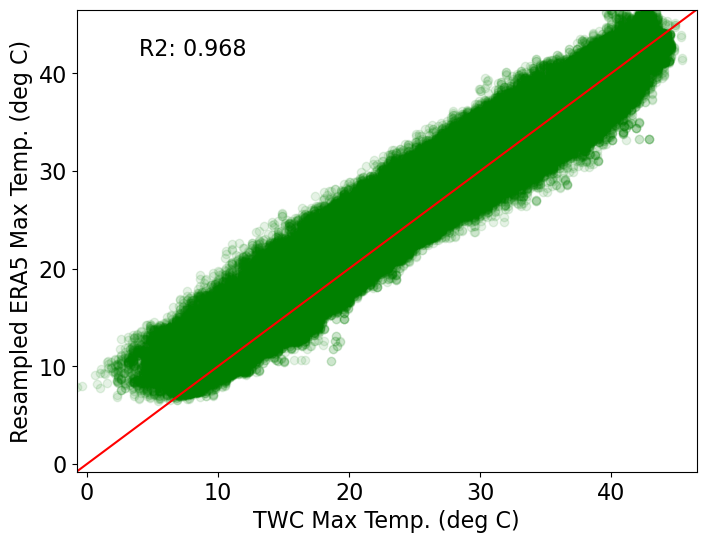

In [4]:
rmse = calculate_rmse(Y_pred=ml_df['max_temp_era5'], Y_obsv=ml_df['max_temp_twc'])
r2 = calculate_r2(Y_pred=ml_df['max_temp_era5'], Y_obsv=ml_df['max_temp_twc'])

print('RMSE before modeling = {:.3f}'.format(rmse))
print('R2 before modeling= {:.3f}'.format(r2))

scatter_plot(Y_pred=ml_df['max_temp_era5'], Y_obsv=ml_df['max_temp_twc'], xlabel='TWC Max Temp. (deg C)', 
             ylabel='Resampled ERA5 Max Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1, color_format='go')

## Goal

The R2 value between TWC and ERA5 max temp is quite well.However, We will try Machine Learning model to see if we can use ERA5 datasets as predictors to predict high resolution max temperature using TWC Max Temperature as the training data.

------------------

## 4. Making train-test split

__Input variables:__ Weather variables from ERA5 renanalysis dataset, along with topography, lat/lon, month datasets, have been used as input variables/predictors in the ML model. All TWC dataset, except the training data TWC `Maximum Temperature`, has been removed from train-test datasets. 
__Observed/training data:__ TWC `Maximum Temperature` has been used as the training/observed data.

In [5]:
drop_columns = ['index', 'year','day',
                'avg_Rhumid_twc', 'avg_wind_speed_twc', 'min_temp_twc', 
                'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 
                'avg_snow_depth', 'avg_wind_dir', 'min_dew_temp', 'avg_wind_speed_era5',
                'max_wind_speed', 'max_atmPress', 'min_atmPress', 'avg_atmPress', 'min_wind_speed']

x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=ml_df, pred_attr='max_temp_twc', 
exclude_columns=drop_columns, test_perc=0.2, validation_perc=0)

Dropping Columns- ['index', 'year', 'day', 'avg_Rhumid_twc', 'avg_wind_speed_twc', 'min_temp_twc', 'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 'avg_snow_depth', 'avg_wind_dir', 'min_dew_temp', 'avg_wind_speed_era5', 'max_wind_speed', 'max_atmPress', 'min_atmPress', 'avg_atmPress', 'min_wind_speed'] 

Predictors: Index(['MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'aspect',
       'avg_Cloud', 'avg_Rhumid_era5', 'avg_dew_temp', 'elevation', 'lat',
       'lon', 'max_Rhumid', 'max_dew_temp', 'max_temp_era5', 'min_Rhumid',
       'min_temp_era5', 'month', 'slope', 'total_precip'],
      dtype='object')


__As we are using CV for hyperparameter tuning, not creating any validation dataset.__

In [6]:
print('x_train length', len(x_train))
print('x_val length', len(x_val))
print('x_test length', len(x_test))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')
print(f'num. of test dates: {len(test_dates)}')

x_train length 1809500
x_val length 0
x_test length 452760
num. of training dates: 1175
num. of validation dates: 0
num. of test dates: 294


In [7]:
x_train.head()

,MaxDown_SR,MaxNet_SR,TotDown_SR,TotNet_SR,aspect,avg_Cloud,avg_Rhumid_era5,avg_dew_temp,elevation,lat,lon,max_Rhumid,max_dew_temp,max_temp_era5,min_Rhumid,min_temp_era5,month,slope,total_precip
0,2.763220,2.295930,23.151918,19.127819,152.862244,0.582584,26.554916,9.906414,22.050282,39.413143,-122.126717,47.560509,15.034322,41.465519,11.675686,24.098717,6,80.139702,0.069477
1,2.735067,2.274148,22.805859,18.839409,176.142258,0.593541,26.782413,10.183108,20.403061,39.413143,-122.090721,48.167271,14.924334,41.563393,11.958647,24.199512,6,89.520233,0.075222
2,2.712090,2.256796,22.491453,18.581324,179.873138,0.604181,27.072355,10.443419,20.524334,39.413143,-122.054718,48.745861,14.890730,41.603294,12.248486,24.249950,6,89.433556,0.080350
3,2.707598,2.255265,22.290098,18.431551,139.173294,0.613686,27.585321,10.645221,22.943249,39.413143,-122.018715,49.223835,15.129926,41.436172,12.562887,24.120535,6,68.663231,0.083275
4,2.822616,2.342312,24.099400,19.932610,145.411133,0.558859,26.006777,9.033833,30.534155,39.377144,-122.234718,46.599796,15.414620,41.227329,10.588063,23.672356,6,82.163490,0.033245


--------------------------

## 5. Looking into Mutual Information (MI) score to select preliminary input variables

`MI score` and `feature importance plot` are ways to determine which predictors are most important in predicting the target variable.  The `MI score` and `predictor/feature importance plot` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

max_temp_era5      1.813736
min_temp_era5      0.852351
month              0.722282
TotDown_SR         0.677555
TotNet_SR          0.633558
MaxDown_SR         0.616963
MaxNet_SR          0.571914
avg_Rhumid_era5    0.465014
min_Rhumid         0.447983
max_Rhumid         0.360414
avg_Cloud          0.355048
max_dew_temp       0.262007
avg_dew_temp       0.219088
total_precip       0.190495
elevation          0.041263
slope              0.040482
aspect             0.039382
lat                0.026829
lon                0.025987
dtype: float64

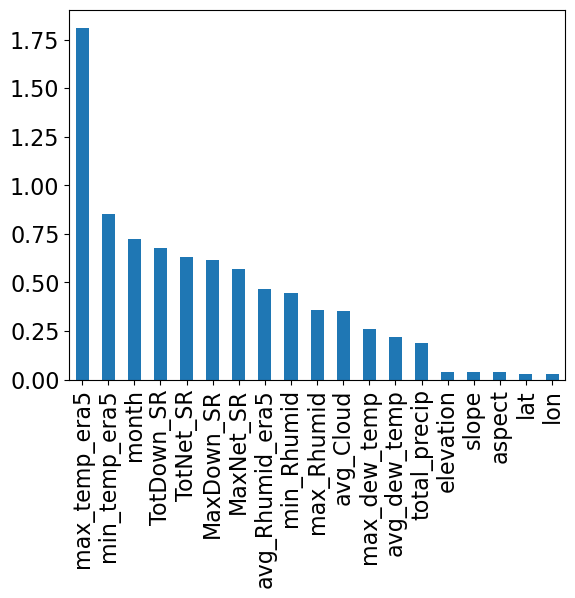

In [17]:
mutual_info_temp = calculate_plot_mutual_information(x_train=x_train, y_train=y_train)
mutual_info_temp

---------------------

## 6. Model training+hyperparamter tuning

Tuned GOSS (LightGBM) model for 09 hyperparameters with 10-fold Randomized CV. A total of 500 combinations of hyperparameters were tested. The hyperparameter space can be found at `ML_utils.ipynb` script. 

In [8]:
# the hyperparameters provided in the following dictionary have been set by hyperparameter tuning
lgbm_param_dict = {'n_estimators': 250,
                   'max_depth': 13,
                   'learning_rate': 0.05,
                   'subsample': 0.6,
                   'colsample_bytree': 0.8,
                   'colsample_bynode': 0.7 ,
                   'path_smooth': 0.3,
                   'num_leaves': 70,
                   'min_child_samples': 40,
                   'data_sample_strategy': 'goss'
                  }
# when tuning hyperparameters set params_dict=None.
trained_lgbm_maxtemp = train_model(x_train, y_train, params_dict=lgbm_param_dict, model='lgbm', n_jobs=-1,
                    load_model=False, save_model=True, save_folder='./saved_models', save_name='lgbm_max_temp',
                    # hyperparameter tuning arguments
                    tune_hyperparameters=False, repeated_Kfold=False, n_folds=10, n_iter=50, n_repeats=5)

[LightGBM] [Info] Total Bins 4276
[LightGBM] [Info] Number of data points in the train set: 1809500, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 24.757177
Train RMSE = 0.895
Train R2 = 0.989
model training time 0.208 mins


In [9]:
trained_lgbm_maxtemp

LGBMRegressor(colsample_bynode=0.7, colsample_bytree=0.8,
              data_sample_strategy='goss', deterministic=True,
              force_row_wise=True, learning_rate=0.05, max_depth=13,
              min_child_samples=40, n_estimators=250, n_jobs=-1, num_leaves=70,
              path_smooth=0.3, random_state=0, subsample=0.6,
              tree_learner='serial')

--------------

## 7. Train-test dataset perforamnce evaluation

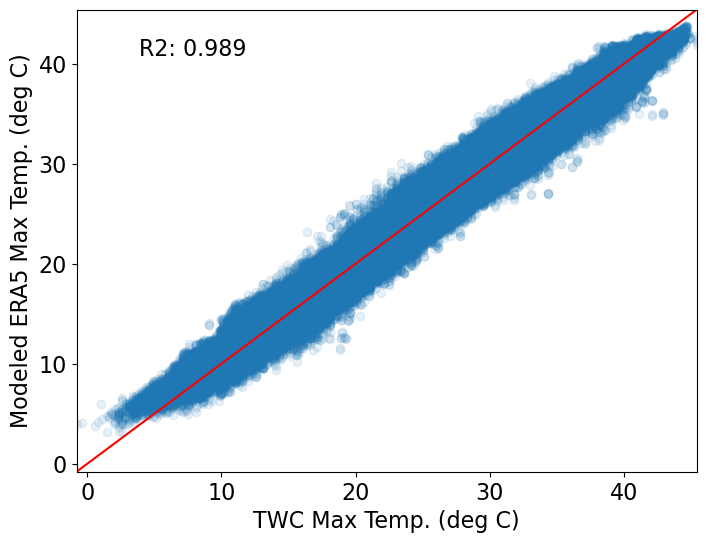

In [10]:
# Performance on train dataset
y_pred_train = trained_lgbm_maxtemp.predict(x_train)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_train, 
             xlabel='TWC Max Temp. (deg C)', ylabel='Modeled ERA5 Max Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1)

Test RMSE = 1.037
Test R2 = 0.987


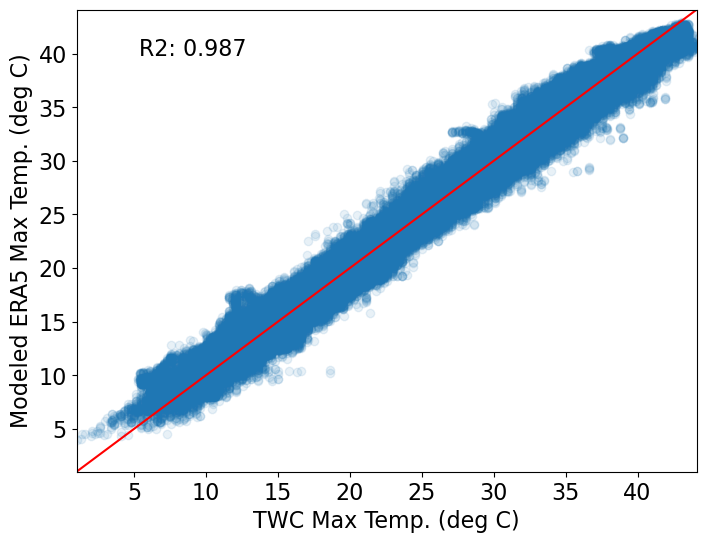

In [11]:
# Performance on test dataset
y_pred_test = trained_lgbm_maxtemp.predict(x_test)
print('Test RMSE = {:.3f}'.format(calculate_rmse(Y_pred=y_pred_test, Y_obsv=y_test)))
print('Test R2 = {:.3f}'.format(calculate_r2(Y_pred=y_pred_test, Y_obsv=y_test)))


scatter_plot(Y_pred=y_pred_test, Y_obsv=y_test, 
             xlabel='TWC Max Temp. (deg C)', ylabel='Modeled ERA5 Max Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1)

------------

## 8. Evaluating model's predictor importance plot

The `predictor/feature importance plot` is a way of seeing which input variables are regarded the most important by the model. The predictor importance plot here is based on `Impurity-based feature importance` which is prone to high-cardinality. I would recoomend looking into [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) to have a more rigorous understanding of feature importance. The `predictor/feature importance plot` and `MI score` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

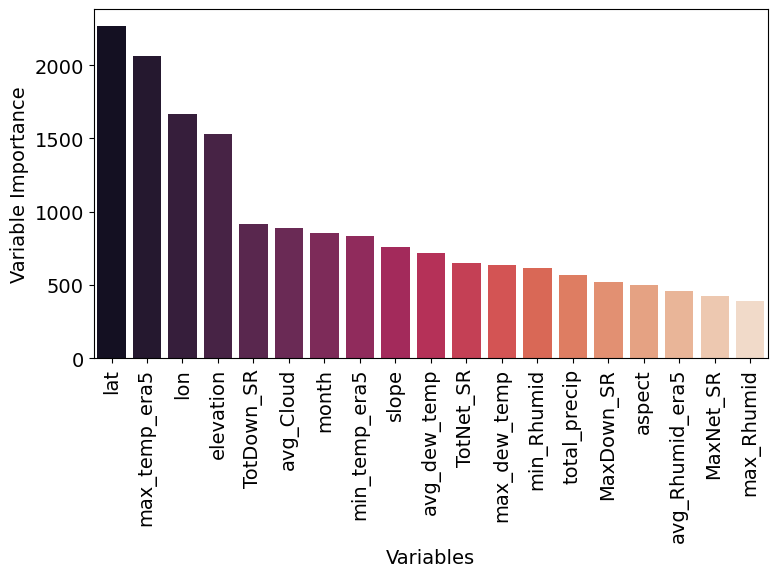

In [12]:
# preditor importance plot
plot_predictor_importance(trained_model=trained_lgbm_maxtemp, x_train=x_train, outdir=None, predictor_imp_keyword='lgbm')

--------------------

## 9. Evaluation model performance for randomly selected dates from the test dataset

Our objective is to improve spatial resolution of daily weather datasets. So, we chcek model performance on randomly selected dataes from the test datasets.

__The combined dataset contains data after 2019-08 that was later filtered out in ml_df. However, we are using the combined_df (cmobined_dataset) to test performace for randomly selected dates which are in test dataset. Also, we are checking performance of dates after 2019-08 (with resolution issue) for which the model wasn't trained for.__

In [13]:
test_dates[1:20]

[20151213,
 20180619,
 20170617,
 20180625,
 20171005,
 20180110,
 20181015,
 20170214,
 20170123,
 20151217,
 20151020,
 20180409,
 20170203,
 20181012,
 20160419,
 20160919,
 20161007,
 20190302,
 20151006]

In [14]:
# to check if a date is in test dataset
if 20160410 in test_dates:
    print(True)

True


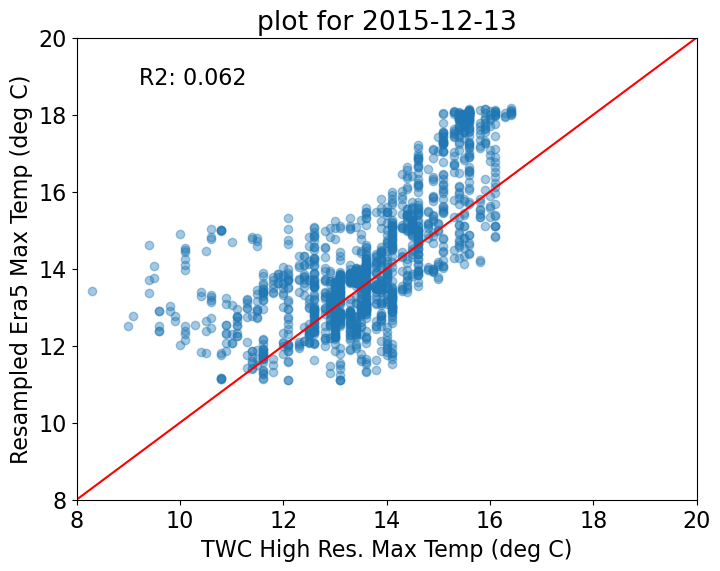

In [12]:
twc_era5_df_sample = combined_df[combined_df.date==20151213]
era5_maxtemp = twc_era5_df_sample['max_temp_era5'] 
y_02 = twc_era5_df_sample[['max_temp_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC High Res. Max Temp (deg C)', ylabel='Resampled Era5 Max Temp (deg C)', 
             title='plot for 2015-12-13', alpha=0.4, axis_lim=[8, 20])

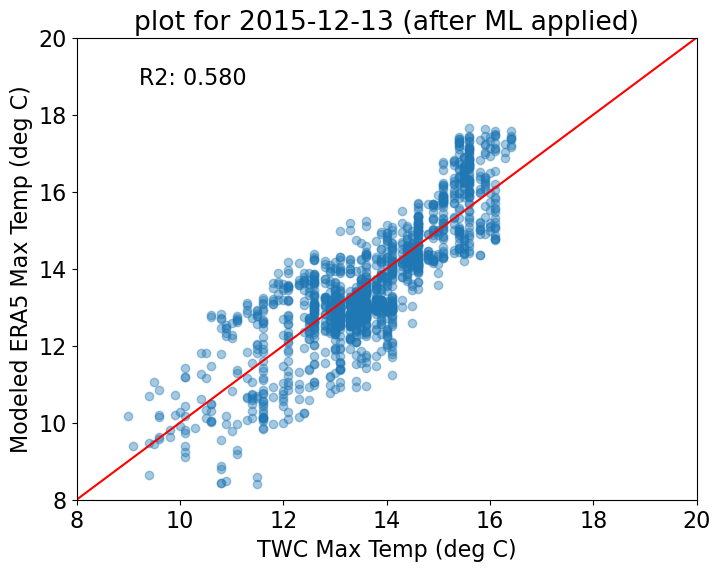

In [16]:
twc_era5_df_sample = combined_df[combined_df.date==20151213]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['max_temp_twc']].values

y_pred_train = trained_lgbm_maxtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Max Temp (deg C)', ylabel='Modeled ERA5 Max Temp (deg C)', 
             title='plot for 2015-12-13 (after ML applied)', alpha=0.4, axis_lim=[8, 20])

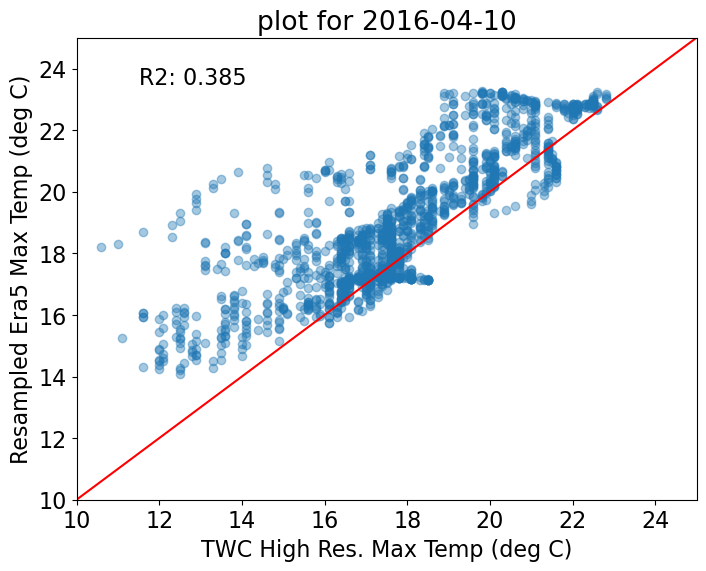

In [13]:
twc_era5_df_sample = combined_df[combined_df.date==20160410]
era5_maxtemp = twc_era5_df_sample['max_temp_era5'] 
y_02 = twc_era5_df_sample[['max_temp_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC High Res. Max Temp (deg C)', ylabel='Resampled Era5 Max Temp (deg C)', 
             title='plot for 2016-04-10', alpha=0.4,axis_lim=[10, 25])

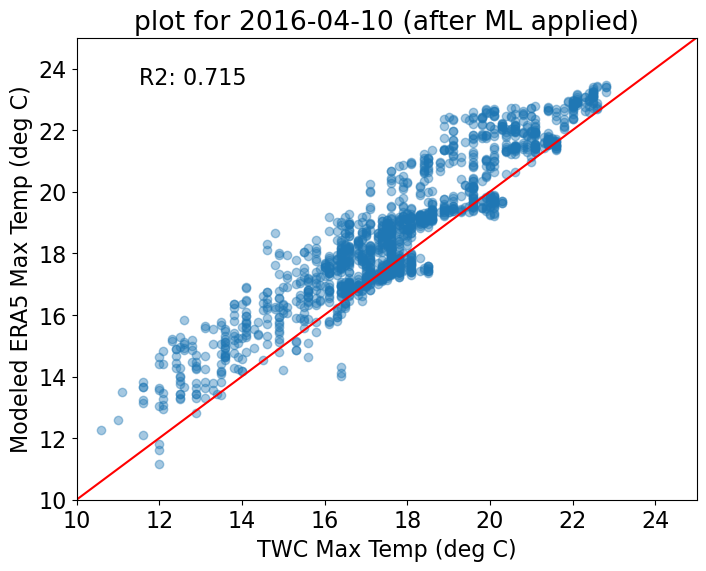

In [14]:
twc_era5_df_sample = combined_df[combined_df.date==20160410]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['max_temp_twc']].values

y_pred_train = trained_lgbm_maxtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Max Temp (deg C)', ylabel='Modeled ERA5 Max Temp (deg C)', 
             title='plot for 2016-04-10 (after ML applied)', alpha=0.4, axis_lim=[10, 25])

### Dates after 2019-08

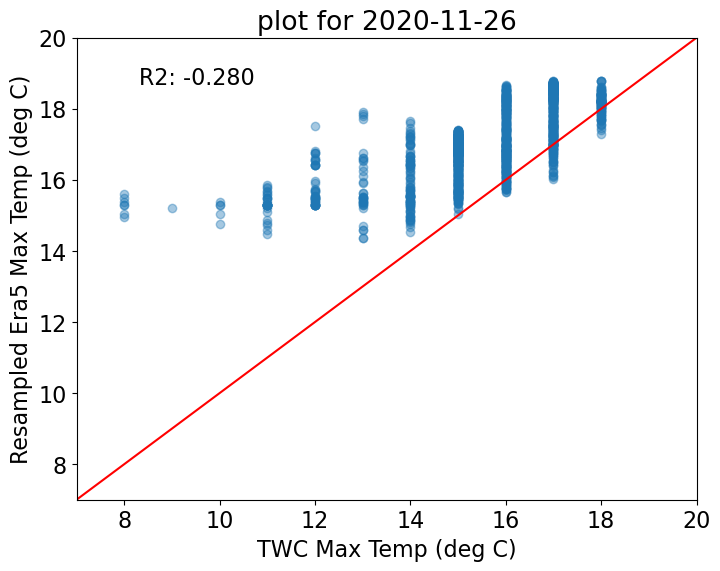

In [20]:
twc_era5_df_sample = combined_df[combined_df.date==20201126]
era5_maxtemp = twc_era5_df_sample['max_temp_era5'] 
y_02 = twc_era5_df_sample[['max_temp_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Max Temp (deg C)', ylabel='Resampled Era5 Max Temp (deg C)', 
             title='plot for 2020-11-26', alpha=0.4, axis_lim=[7, 20])

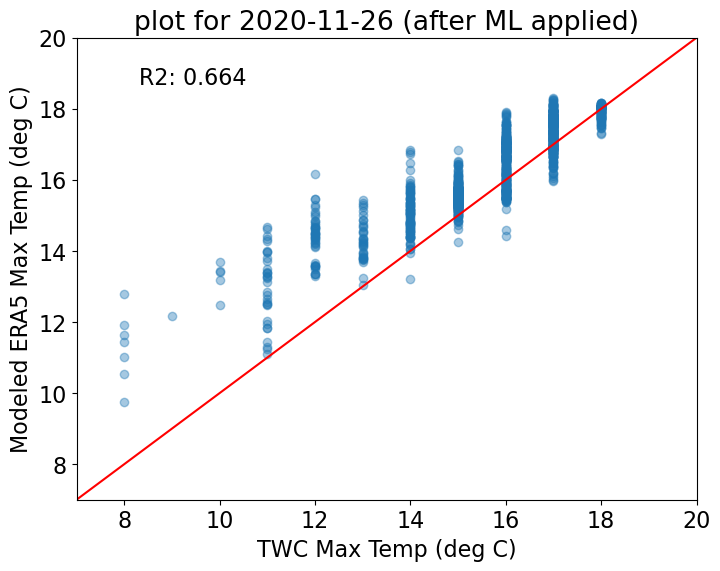

In [17]:
twc_era5_df_sample = combined_df[combined_df.date==20201126]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['max_temp_twc']].values

y_pred_train = trained_lgbm_maxtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Max Temp (deg C)', ylabel='Modeled ERA5 Max Temp (deg C)', 
             title='plot for 2020-11-26 (after ML applied)', alpha=0.4, axis_lim=[7, 20])

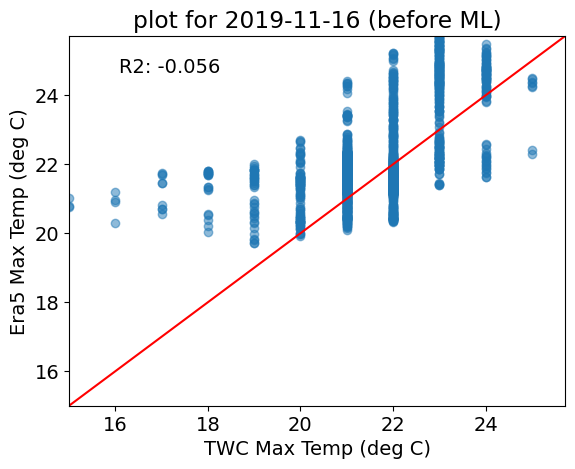

In [21]:
twc_era5_df_sample = combined_df[combined_df.date==20191116]
era5_maxtemp = twc_era5_df_sample['max_temp_era5'] 
y_02 = twc_era5_df_sample[['max_temp_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Max Temp (deg C)', ylabel='Era5 Max Temp (deg C)', 
             title='plot for 2019-11-16')

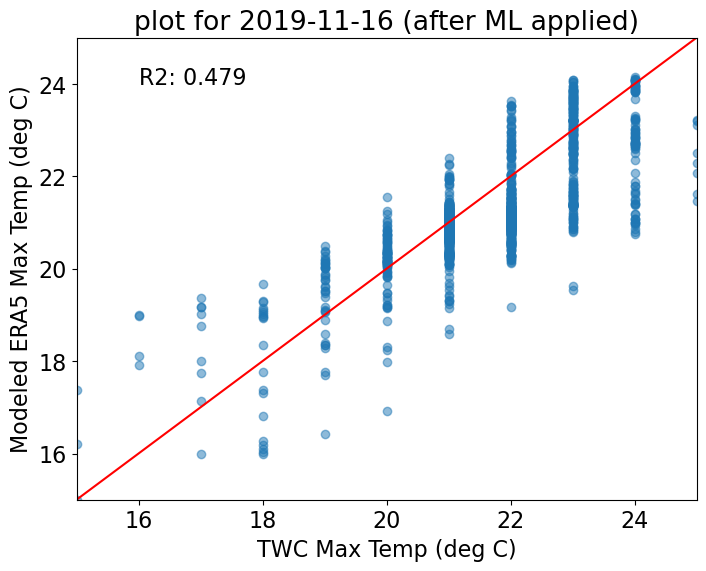

In [18]:
twc_era5_df_sample = combined_df[combined_df.date==20191116]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['max_temp_twc']].values

y_pred_train = trained_lgbm_maxtemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Max Temp (deg C)', ylabel='Modeled ERA5 Max Temp (deg C)', 
             title='plot for 2019-11-16 (after ML applied)')

__The plots of before and after modeling performance for randomly selected dates from test dataset shows that the model is performing quite well for individual dates.__

------------------

## 10. Estimating overall model perforamcne on test dataset

Here, we are looking into before and after modeling R2 score for all dates in the test dataset.

In [23]:
result_calc_test_dataset(trained_ml_model=trained_lgbm_maxtemp, list_test_dates=test_dates, x_train=x_train, 
                         combined_dataset=ml_df, era5_target_variable='max_temp_era5', 
                         twc_target_variable='max_temp_twc', 
                         output_csv='./saved_models/max_temp_test_results.csv')

294 number of total dates in test dataset
180 days have R2 > 0.6
215 days have R2 > 0.5
250 days have R2 > 0.3


,date,before_ML_R2,after_ML_R2
0,20151130,0.360185,0.651193
1,20151213,0.061835,0.599871
2,20180619,0.226394,0.800842
3,20170617,-1.894788,-0.103816
4,20180625,0.260018,0.722858
...,...,...,...
289,20170630,0.533857,0.678112
290,20170911,-0.414561,0.298349
291,20181002,-0.051409,0.550217
292,20161207,0.220686,0.804087


In [22]:
import seaborn as sns

results_csv = './saved_models/max_temp_test_results.csv'
results_df = pd.read_csv(results_csv)

R2_below_zero_before_model = len(results_df[results_df['before_ML_R2']<0])
R2_below_zero_after_model = len(results_df[results_df['after_ML_R2']<0])

print(f'Before ML model {R2_below_zero_before_model} R2 remains negative')
print(f'After ML model {R2_below_zero_after_model} R2 remains negative')

Before ML model 112 R2 remains negative
After ML model 21 R2 remains negative


Text(0, 0.5, 'R2')

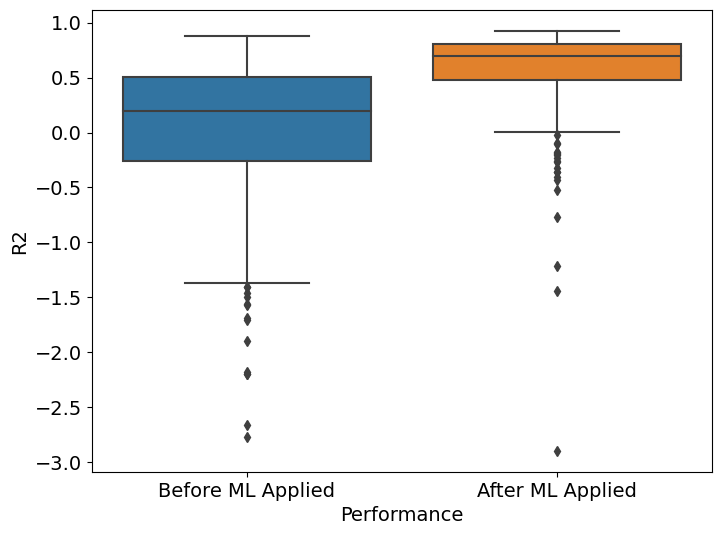

In [23]:
# Boxplot of before and after ML performance
results_df = results_df[['before_ML_R2', 'after_ML_R2']]
results_df = results_df.rename(columns={'before_ML_R2': 'Before ML Applied', 'after_ML_R2': 'After ML Applied'})
results_df = results_df[results_df['Before ML Applied']>-3]
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='variable', y='value', data=pd.melt(results_df))
ax.set_xlabel('Performance')
ax.set_ylabel('R2')

__The boxplot of before and after modeling R2 proves that the model is performing very well. From negative to very low R2 values, the model increases the R2 value which proves that the model interpolates the the daily weather data at high-resolution succesfully.__

----------------

## 11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

In [24]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
ref_raster = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/max_temp/max_temp_20150630.tif'
output_folder = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp'

run_model_to_generate_prediction(trained_ml_model=trained_lgbm_maxtemp, x_train=x_train, 
                                 predictor_era5_dataset=era5_data, ref_raster=ref_raster, 
                                 output_folder=output_folder, variable_name_keyword='max_temp')

Generating model interpolated daily rasters...
All daily rasters generated


### Visualization of downscaled results 

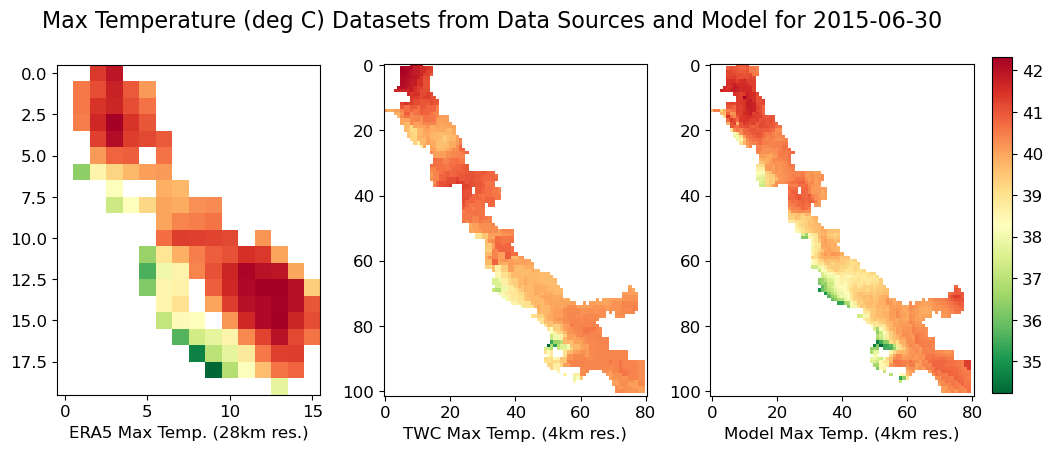

In [6]:
era5_data = '../../datasets/weather_raster_data/cities_California/era5_data/original_28km_rasters/max_temp/max_temp_20150630.tif'
twc_data = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/max_temp/max_temp_20150630.tif'
downscaled_data = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp/max_temp_20150630.tif'


plot_era5_twc_downscaled_rasters(era5_data, twc_data, downscaled_data,  
                                 title= 'Max Temperature (deg C) Datasets from Data Sources and Model for 2015-06-30',
                                 suptitle_pos=0.75,
                                 xlabels=['ERA5 Max Temp. (28km res.)',
                                          'TWC Max Temp. (4km res.)',
                                          'Model Max Temp. (4km res.)'],
                                 cbar_axes_pos=[1, 0.27, 0.02, 0.42])

---------------------

---------------------

# DL model (MLP) for `Max Temperature`

To compare whether deep learning can achieve similar performance for `MAx Temperature` we implemented MLP on this variable. While implementing the MLP, it took considerable amount of time to figure out an architecture that had good performance. Still, I believe that the MLP performance isn't optimal. The R2 values for the train and test set (0.967 and 0.968 respectively) are similar to R2 perfoamance (0.968) for `resampled ERA5 max temperature vs TWC max temperature` before applying the DL mode, which means the model isn't actually achieving anything. The model performance might improve with a better architecture. The GOSS (LightGBM) performance is better than the MLP performance. 

__Install pytorch first if not already installed__

In [2]:
# !pip3 install torch torchvision torchaudio

In [1]:
from ipynb.fs.full.NN_Pytorch import *

## 1. Loading Data

In [2]:
combined_dataset =  '../../datasets/processed_parquet_data/cities_California/twc_era5_weather_data_cities_California.parquet'
combined_df = pd.read_parquet(combined_dataset)

print(f'TWC ERA5 df columns: {combined_df.columns}')

TWC ERA5 df columns: Index(['index', 'avg_wind_speed_twc', 'date', 'year', 'month', 'day', 'lon',
       'lat', 'avg_Rhumid_twc', 'max_temp_twc', 'min_temp_twc', 'MaxNet_SR',
       'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'min_temp_era5',
       'max_temp_era5', 'max_Rhumid', 'TotDown_SR', 'min_wind_speed',
       'total_precip', 'avg_wind_speed_era5', 'eto', 'min_atmPress', 'slope',
       'avg_Cloud', 'avg_atmPress', 'max_dew_temp', 'avg_SM_L1',
       'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid_era5', 'etr', 'avg_ST_L1',
       'avg_snow_depth'],
      dtype='object')


------------------

## 2. Additional data filtering

__Filtering out rows after 2019-08. TWC weather data, especially temperature data has resolution issue (1 degree resolution, no intermediate float values). Therefore, not including them in model training.__

In [3]:
ml_df = combined_df[combined_df.date <=20190730]
sorted(ml_df.date)[0], sorted(ml_df.date)[-1]

(20150630, 20190730)

--------------------------------

## 3. Evaluation before model performance/relationship

Same as the green scatter plot between `resampled ERA5 max temperature (4km) vs TWC max temperature (4km)`

--------------------------

## 4. Making train-validation-test split

__Input variables:__ Weather variables from ERA5 renanalysis dataset, along with topography, lat/lon, month datasets, have been used as input variables/predictors in the ML model. All TWC dataset, except the training data TWC `Maximum Temperature`, has been removed from train-test datasets. 
__Observed/training data:__ TWC `Maximum Temperature` has been used as the training/observed data.

In [4]:
drop_columns = ['index', 'year','day',
                'avg_Rhumid_twc', 'avg_wind_speed_twc', 'min_temp_twc', 
                'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 
                'avg_snow_depth', 'avg_wind_dir', 'min_dew_temp', 'avg_wind_speed_era5',
                'max_wind_speed', 'max_atmPress', 'min_atmPress', 'avg_atmPress', 'min_wind_speed',
                'aspect', 'slope']

x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=ml_df, pred_attr='max_temp_twc', 
exclude_columns=drop_columns, test_perc=0.2, validation_perc=0.2)

Dropping Columns- ['index', 'year', 'day', 'avg_Rhumid_twc', 'avg_wind_speed_twc', 'min_temp_twc', 'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 'avg_snow_depth', 'avg_wind_dir', 'min_dew_temp', 'avg_wind_speed_era5', 'max_wind_speed', 'max_atmPress', 'min_atmPress', 'avg_atmPress', 'min_wind_speed', 'aspect', 'slope'] 

Predictors: Index(['MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'avg_Cloud',
       'avg_Rhumid_era5', 'avg_dew_temp', 'elevation', 'lat', 'lon',
       'max_Rhumid', 'max_dew_temp', 'max_temp_era5', 'min_Rhumid',
       'min_temp_era5', 'month', 'total_precip'],
      dtype='object')


In [5]:
print('x_train length', len(x_train))
print('x_test length', len(x_test))
print('x_val length', len(x_val))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of test dates: {len(test_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')

x_train length 1356740
x_test length 452760
x_val length 452760
num. of training dates: 881
num. of test dates: 294
num. of validation dates: 294


-------------------

## 5. Loading data in Dataloader

Here, we load the train-validation-test datasets in a Dataloader. We decided a batch size of `128`. But we encourgae to check out with other batch size, such as 32/64/256 to optimize model performance.

In [11]:
from torch.utils.data import TensorDataset, DataLoader

batch_size=128

train_features = torch.tensor(np.array(x_train)).float()
train_target = torch.tensor(np.array(y_train)).float()
train_dataset = TensorDataset(train_features, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_features = torch.tensor(np.array(x_test)).float()
test_target = torch.tensor(np.array(y_test)).float()
test_dataset = TensorDataset(test_features, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_features = torch.tensor(np.array(x_val)).float()
valid_target = torch.tensor(np.array(y_val)).float()
valid_dataset = TensorDataset(valid_features, valid_target)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

-------------------------

## 6. Model training

I adjusted the architectures and hyperparameters, such as hidden layers, nodes in hidden layers, weight decay, learning rate, manually and decided architecture-hyperparameters that was giving the best model result. I strongly encourage performing a `Grid Search` type search with different types of architectures and hyperparameters. This will help with finding the best set of architecture and hyperparameters and model performance will definitely improve.

In [12]:
nn_model = NeuralNetwork(n_inputs=17, n_hiddens_list=[40, 20], n_outputs=1, dropout=0.1,
                         activation_func='relu', device='cuda')

trained_nn_maxtemp, train_losses, valid_losses, train_mean, train_std = \
train_model(model=nn_model, train_dataloader=train_dataloader, 
            save_folder='./saved_models', savename='nn_maxtemp',
            validation_dataloader=valid_dataloader, 
            early_stop=True, start_EarlyStop_count_from_epoch=50, patience=10,
            n_epochs=100, method='adam', weight_decay=0.01, learning_rate=0.00001,
            device='cuda', verbose=True, standardization=True)

Model running on cuda....
avg. MSE Loss in epoch 1: train loss: 443.4988065546863 | validation loss: 181.15619745680408
avg. MSE Loss in epoch 2: train loss: 66.73753048968764 | validation loss: 24.99974085342554
avg. MSE Loss in epoch 3: train loss: 27.300111758214122 | validation loss: 11.530373309546773
avg. MSE Loss in epoch 4: train loss: 20.15332239393918 | validation loss: 13.707368252302981
avg. MSE Loss in epoch 5: train loss: 17.281244701979297 | validation loss: 7.872913191586716
avg. MSE Loss in epoch 6: train loss: 15.454802114108823 | validation loss: 7.866985074944116
avg. MSE Loss in epoch 7: train loss: 14.065808751628085 | validation loss: 15.341974400207105
avg. MSE Loss in epoch 8: train loss: 12.872092855111609 | validation loss: 12.789688769675298
avg. MSE Loss in epoch 9: train loss: 11.935959886784824 | validation loss: 4.742815121612419
avg. MSE Loss in epoch 10: train loss: 11.157621816869051 | validation loss: 4.716331896773835
avg. MSE Loss in epoch 11: trai

### comment on `Early Stopping`:

I implemented something `unconventional` in `early stopping` in this model. From multiple training runs, I noticed that the training stops early with conventional early stopping. This happens because at a random epoch the validation loss might get very low and the model uses that validation loss to check early stopping criteria. At that point, the training loss might not be minimized and there is large gap between train and validation loss. I ran models for a good number of epochs without early stopping and noticed that even after that very low (sudden) validation loss point training loss decreases and validation loss becomes more generalized (the gap between train and valiation loss decreases). In my thought, we should let the model train for some epochs and then start monitoring `early stopping`. That's why I incorporated `start_EarlyStop_count_from_epoch` argument in the `train_model()` function for the neural network.  

I experimented with different model architecture with 02/03/04 hidden layers, nodes going from 10-100, and learning rates 0.01-0.00001. The [40, 20] architecture with learning rate 0.00001 provided me the best performance. But may be a differnt architecture and hyperparameters set will provide better performance and `conventional early stopping` can be implemented instead of `unconventional early stopping`.

-------------------

## 7. Train-validation-test dataset perforamnce evaluation

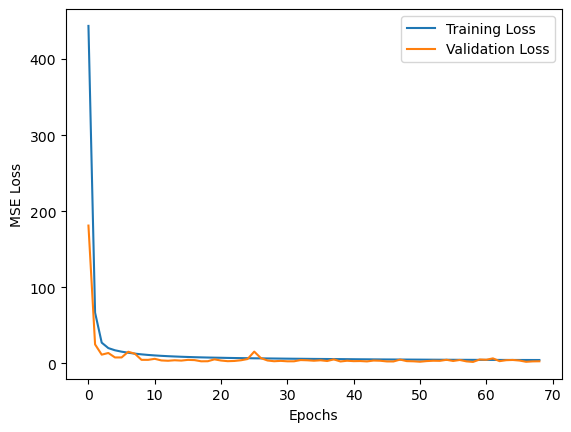

In [13]:
# Model training performance plot

fig, ax = plt.subplots()
ax.plot(train_losses, label='Training Loss')
ax.plot(valid_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.legend()

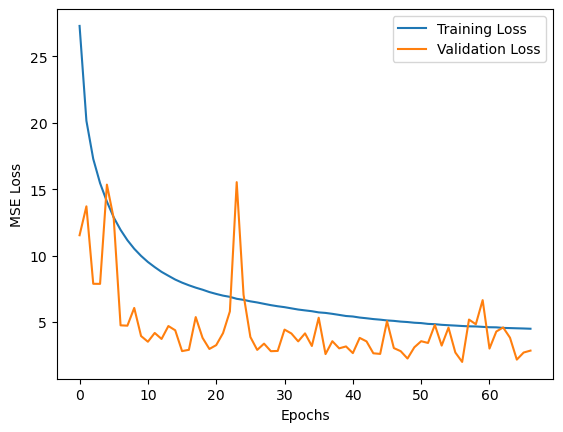

In [14]:
# # Model training performance plot with very high losses in the beginning removed

train_losses_1 = train_losses[2:]
valid_losses_1 = valid_losses[2:]

fig, ax = plt.subplots()
ax.plot(train_losses_1, label='Training Loss')
ax.plot(valid_losses_1, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.legend()

### Comment on Train-Validation Loss
The above two plots show the train-validation loss per epoch during model training. In the first couple of epochs, there is a large drop is loss values. In the second plot, I removed the high train-validation losses during the first two epochs to better visualize how the losses look like during the later stage of model training.

The 2nd plot shows that the train-validation loss gap has decreased but the validation loss hasn't stabilized. I tried different model architectures and hyperparameters values and till now this is the best performance. I recommend further optimizing the architecture for better model performance. 

### Performance on train-test dataset

Now, I load the trained model and check performance of both train and test dataset.

In [15]:
# model structure initialization
nn_model = NeuralNetwork(n_inputs=17, n_hiddens_list=[40, 20], n_outputs=1, dropout=0.1,
                         activation_func='relu', device='cuda')

# loading trained model
trained_nn_maxtemp, train_losses, valid_losses, train_mean, train_std = \
load_trained_model(model_initialized=nn_model, model_path='./saved_models/nn_maxtemp.pt', 
                   train_loss_path='./saved_models/nn_maxtemp_trainloss.pkl', 
                   validation_loss_path='./saved_models/nn_maxtemp_validationloss.pkl', 
                   train_mean_path='./saved_models/nn_maxtemp_trainmean.pkl', 
                   train_std_path='./saved_models/nn_maxtemp_trainstd.pkl', 
                   standardization=True, train_scaler_path=None)

Model running on cuda....
*****Trained model loaded and evaluation mode activated*****


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

device='cuda'
mse_func = torch.nn.MSELoss()  # mse function

trained_nn_maxtemp.eval() # trained model in evaluadtion mode

train_features = train_features
test_features = test_features
train_target = train_target.reshape(-1, 1)
test_target = test_target.reshape(-1, 1)
 
# Standardization and moving to cuda (if device is cuda)
Xs_train = (train_features - train_mean) /  train_std
Xs_train = Xs_train.to(device)

Xs_test = (test_features - train_mean) /  train_std
Xs_test = Xs_test.to(device)

# Prediction on train and test dataset
Y_train_pred = trained_nn_maxtemp(Xs_train).cpu().detach()
Y_test_pred = trained_nn_maxtemp(Xs_test).cpu().detach()


# calculating MSE and RMSE
train_mse = mse_func(Y_train_pred, train_target).item() 
train_rmse = mean_squared_error(y_true=train_target, y_pred=Y_train_pred, squared=False)    

test_mse = mse_func(Y_test_pred, test_target).item() 
test_rmse = mean_squared_error(y_true=test_target, y_pred=Y_test_pred, squared=False)    


# making list of predictions
train_observed = train_target.numpy().flatten().tolist()
train_predicted = Y_train_pred.numpy().flatten().tolist()


test_observed = test_target.numpy().flatten().tolist()
test_predicted = Y_test_pred.numpy().flatten().tolist()
    
print('Train MSE :', train_mse)
print('Train RMSE:', train_rmse)
print('Test MSE :', test_mse)
print('Test RMSE:', test_rmse)

Train MSE : 2.532519578933716
Train RMSE: 1.5913892
Test MSE : 2.405914068222046
Test RMSE: 1.5511009


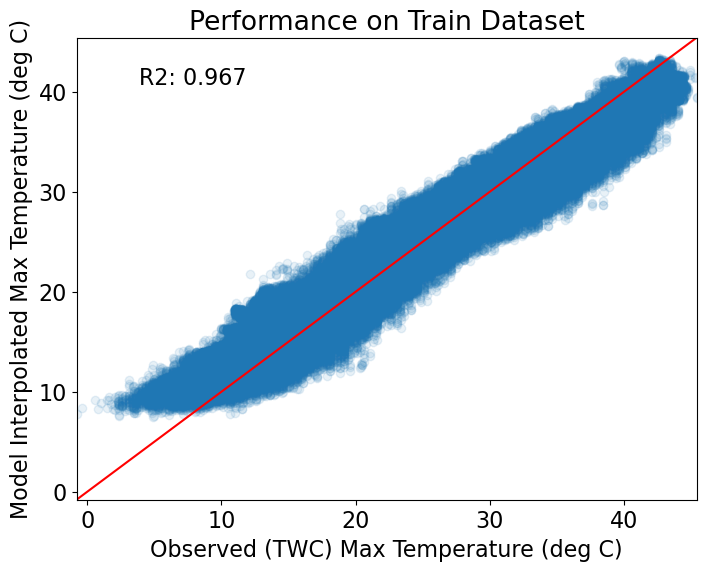

In [17]:
train_observed = pd.Series(train_observed)
train_predicted = pd.Series(train_predicted)

scatter_plot(Y_pred=train_predicted, Y_obsv=train_observed, 
             xlabel='Observed (TWC) Max Temperature (deg C)', ylabel='Model Interpolated Max Temperature (deg C)',
             title='Performance on Train Dataset', alpha=0.1)

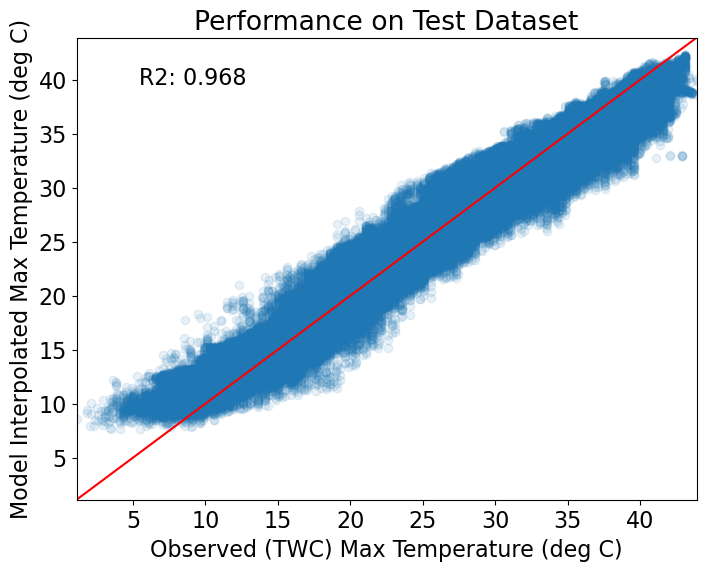

In [18]:
test_observed = pd.Series(test_observed)
test_predicted = pd.Series(test_predicted)

scatter_plot(Y_pred=test_predicted, Y_obsv=test_observed, 
             xlabel='Observed (TWC) Max Temperature (deg C)', ylabel='Model Interpolated Max Temperature (deg C)',
             title='Performance on Test Dataset', alpha=0.1)

### Comment on train-test results

The `train-test RMSE` seems very close. But these R2 values are similar/less than R2 perfoamance (0.968) for `resampled ERA5 max temperature vs TWC max temperature` before applying the DL mode, which means the model isn't actually achieving anything. Further optimization with better architecture and hyperparameters might improve the performance of the DL model. 

-------------------

---------------